In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from scipy.optimize import curve_fit
from scipy.stats import sem
import h5py
from pathlib import Path
from collections.abc import Iterable

In [3]:
datapath = Path.cwd() / "data"
figurepath = Path.cwd().parent / "figures"

In [4]:
W = 5.88    # Figure width in inches, approximately A4-width - 2*1.25in margin
plt.rcParams.update({
    'figure.figsize': (W, W),#/(4/3)),     # 1:1 aspect ratio
    'font.size' : 11,                   # Set font size to 11pt
    'axes.labelsize': 11,               # -> axis labels
    'legend.fontsize': 10,              # -> legends
    'font.family': 'lmodern',
    'text.usetex': True,
    'text.latex.preamble': (            # LaTeX preamble
        r'\usepackage{lmodern}'
        # ... more packages if needed
    )
})

In [5]:
def set_size(width='thesis', fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    aspect_ratio = 1#(5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * aspect_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


In [6]:
def rearrange_data(arr): #
    res = np.swapaxes(arr,-1,0)
    res = np.swapaxes(res,-2,1)
    return res

def disorder_mean(A, n_samples = None):
    if n_samples is None:
        return np.mean(A,2)
    else:
        return np.mean(A[:,:,0:n_samples],2)

def disorder_std(A, n_samples = None):
    if n_samples is None:
        return np.std(A,2,ddof=1)
    else:
        return np.std(A[:,:,0:n_samples],2,ddof=1)
def disorder_sem(A, n_samples = None):
    if n_samples is None:
        return sem(A,axis=2)
    else:
        return sem(A[:,:,0:n_samples],axis=2)

def symmetrize(arr):
    N = arr.shape[1]
    symarr = np.zeros((arr.shape[0],N//2+1))
    for j in range(0,N//2):
        symarr[:,j] = 0.5*(arr[:,j]+arr[:,N-j-1])
    symarr[:,N//2] = arr[:,N//2]
    return symarr

In [7]:
def idx_transgression(arr,threshold):
    idx = np.zeros(arr.shape[1],dtype=int)
    for j in range(arr.shape[1]):
        found = False
        for i in range(arr.shape[0]):
            if found == False and arr[i,j] >= threshold:
                idx[j] = i
                found = True
        if found == False:
            idx[j] = -1 #be careful that this never breaks things
    return idx

def safeguard_minusone(idx):
    res = np.zeros(idx.shape[0],dtype=float)
    for i in range(idx.shape[0]):
        res[i] = idx[i] if idx[i] != -1 else np.nan
    return res

def mask_transgression(arr,threshold):
    mask = np.zeros(arr.shape,dtype=bool)
    idx = idx_transgression(arr,threshold)
    for j in range(arr.shape[1]):
        if idx[j] != -1:
            mask[idx[j],j]=True
    return mask

def T_transgression(T,arr,threshold):
    idx = idx_transgression(arr,threshold)
    t_past = T[idx]
    t_before = T[[i-1 if i > 0 else 0 for i in idx]]
    arr_past = np.zeros(arr.shape[1])
    arr_before = np.zeros(arr.shape[1])
    t_th = np.zeros(arr.shape[1])
    for j in range(0,arr.shape[1]):
        arr_past[j] = arr[idx[j],j]
        arr_before[j] = arr[idx[j]-1 if idx[j] > 0 else 0,j]

        t_th[j] = (threshold-arr_before[j])/(arr_past[j]-arr_before[j]) * (t_past[j]-t_before[j]) + t_before[j]
    return t_th

In [8]:
def model(x,a,b):
    return a*x**b

In [11]:
jobids = []
params = []
data = []
data_nn = []
folders = [datapath/"xx/h = 3",datapath/"xx/h = 6",datapath/"xx/h = 9",datapath/"xx/h = 12"]
files = ["combined_file_h{}.jld2".format(h) for h in [3,6,9,12]] 
for (i,file) in enumerate(files):
    with h5py.File(folders[i]/file,"r") as f:
        jobids.append(list(map(lambda s: s.decode("UTF-8"),f["jobid"][()])))
        data.append(2-2*np.array([f[f["data"][l]] for l in range(len(f["data"]))]))
        params.append([f[f["params"][l]][()] for l in range(len(f["params"]))])
folders_nn = [datapath/"xx_nn/h = 3",datapath/"xx_nn/h = 6",datapath/"xx_nn/h = 9",datapath/"xx_nn/h = 12"]
files_nn = ["combined_file_h{}.jld2".format(h) for h in [3,6,9,12]] 
for (i,file) in enumerate(files_nn):
    with h5py.File(folders_nn[i]/file,"r") as f:
        jobids.append(list(map(lambda s: s.decode("UTF-8"),f["jobid"][()])))
        data_nn.append(2-2*np.array([f[f["data"][l]] for l in range(len(f["data"]))]))
        params.append([f[f["params"][l]][()] for l in range(len(f["params"]))])

for  i in range(0,len(files)):
    data[i] = np.concatenate(data[i],axis=0)
    data[i] = rearrange_data(data[i])
    data_nn[i] = np.concatenate(data_nn[i],axis=0)
    data_nn[i] = rearrange_data(data_nn[i])

In [12]:
N = 13
hs = [3,6,9,12]
T = 10 ** np.linspace(-3,6,100)
xcenter = N//2
x = np.arange(0,N//2+1,1)
rvals = np.array([abs(pos-xcenter) for pos in range(0,N)])

In [13]:
res = [disorder_mean(data[i]) for i in range(4)]
res_sem = [disorder_sem(data[i]) for i in range(4)]
red = list(map(symmetrize,res))
red_sem = list(map(symmetrize,res_sem))

res_nn = [disorder_mean(data_nn[i]) for i in range(4)]
res_sem_nn = [disorder_sem(data_nn[i]) for i in range(4)]
red_nn = list(map(symmetrize,res_nn))
red_sem_nn = list(map(symmetrize,res_sem_nn))

# h = 3

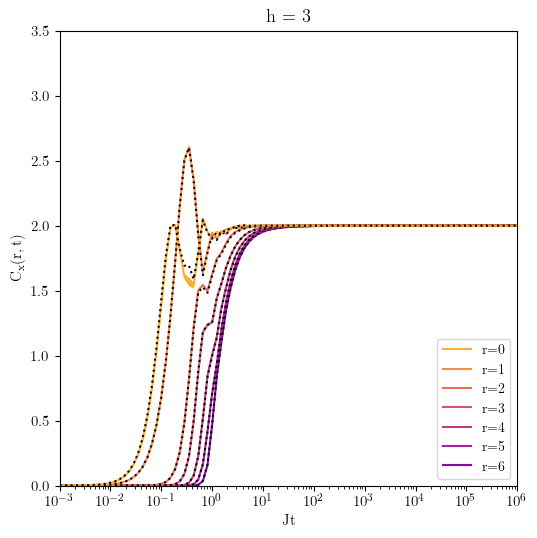

In [14]:
fig = plt.figure(figsize=set_size())
ax = fig.add_subplot(111)

NUM_COLORS = 19//2+2 #11
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
ax.set_xscale("log")
for j in range(0,N//2+1):
    ax.plot(T,red[0][:,j],label="r={}".format(rvals[j]))
    ax.plot(T,red_nn[0][:,j],ls="dotted",c="black")

    ax.fill_between(T, red[0][:,j]-red_sem[0][:,j], red[0][:,j]+red_sem[0][:,j])

handles, labels = ax.get_legend_handles_labels()
order = np.flip(np.arange(0,N//2+1,1))
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc="lower right")
ax.set_xlabel(r"Jt")
ax.set_ylabel(r"$\mathrm{C_x(r,t)}$")
ax.set_title("h = {}".format(hs[0]))
ax.set_xlim(1e-3,1e6)
ax.set_ylim(0,3.5)
plt.show()

# h = 6

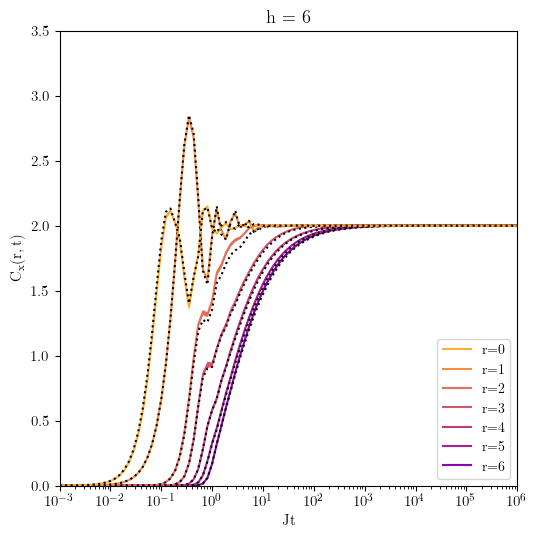

In [15]:
fig = plt.figure(figsize=set_size())
ax = fig.add_subplot(111)

NUM_COLORS = 19//2+2 #11
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
ax.set_xscale("log")
for j in range(0,N//2+1):
    ax.plot(T,red[1][:,j],label="r={}".format(rvals[j]))
    ax.plot(T,red_nn[1][:,j],ls="dotted",c="black")

    ax.fill_between(T, red[1][:,j]-red_sem[1][:,j], red[1][:,j]+red_sem[1][:,j])

handles, labels = ax.get_legend_handles_labels()
order = np.flip(np.arange(0,N//2+1,1))
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc="lower right")
ax.set_xlabel(r"Jt")
ax.set_ylabel(r"$\mathrm{C_x(r,t)}$")
ax.set_title("h = {}".format(hs[1]))
ax.set_xlim(1e-3,1e6)
ax.set_ylim(0,3.5)
plt.show()

# h = 9

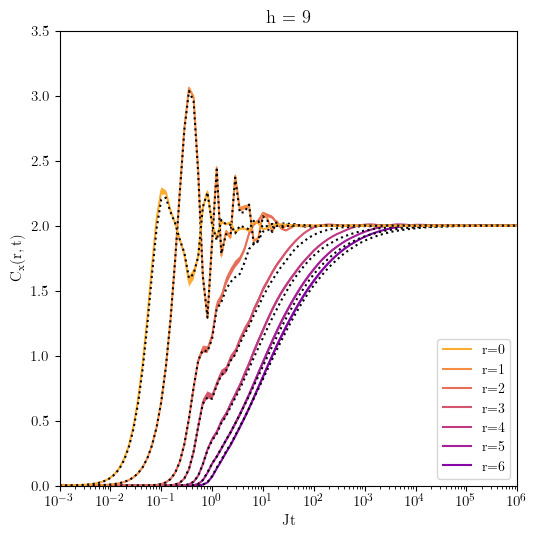

In [16]:
fig = plt.figure(figsize=set_size())
ax = fig.add_subplot(111)

NUM_COLORS = 19//2+2 #11
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
ax.set_xscale("log")
for j in range(0,N//2+1):
    ax.plot(T,red[2][:,j],label="r={}".format(rvals[j]))
    ax.plot(T,red_nn[2][:,j],ls="dotted",c="black")

    ax.fill_between(T, red[2][:,j]-red_sem[2][:,j], red[2][:,j]+red_sem[2][:,j])
    


handles, labels = ax.get_legend_handles_labels()
order = np.flip(np.arange(0,N//2+1,1))
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc="lower right")
ax.set_xlabel(r"Jt")
ax.set_ylabel(r"$\mathrm{C_x(r,t)}$")
ax.set_title("h = {}".format(hs[2]))
ax.set_xlim(1e-3,1e6)
ax.set_ylim(0,3.5)
plt.show()

# h = 12

(0.01, 3.5)

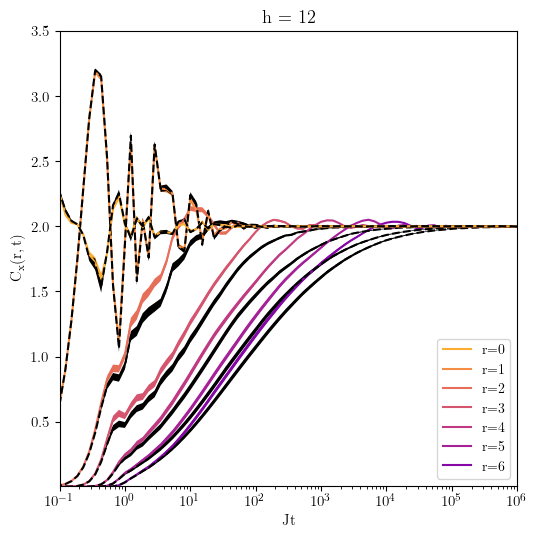

In [17]:
fig = plt.figure(figsize=set_size())
ax = fig.add_subplot(111)

NUM_COLORS = 19//2+2 #11
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
ax.set_xscale("log")
for j in range(0,N//2+1):
    ax.plot(T,red[3][:,j],label="r={}".format(rvals[j]))
    ax.plot(T,red_nn[3][:,j],ls="dashed",c="black")
    #ax.errorbar(T,red[3][:,j],yerr=red_sem[3][:,j],label="r={}".format(rvals[j]),capsize=2)
    #ax.errorbar(T,red_nn[3][:,j],yerr=red_sem_nn[3][:,j],c="black",ls="dashed",capsize=2)

    ax.fill_between(T, red[3][:,j]-red_sem[3][:,j], red[3][:,j]+red_sem[3][:,j])
    ax.fill_between(T, red_nn[3][:,j]-red_sem_nn[3][:,j], red_nn[3][:,j]+red_sem_nn[3][:,j],fc="black")


handles, labels = ax.get_legend_handles_labels()
order = np.flip(np.arange(0,N//2+1,1))
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc="lower right")
ax.set_xlabel(r"Jt")
ax.set_ylabel(r"$\mathrm{C_x(r,t)}$")
ax.set_title("h = {}".format(hs[3]))
ax.set_xlim(1e-1,1e6)
ax.set_ylim(1e-2,3.5)
#ax.set_yscale("log")

In [18]:
rvals[0:7] 

array([6, 5, 4, 3, 2, 1, 0])

/tmp/ipykernel_100743/1483723649.py:14: RuntimeWarning: divide by zero encountered in true_divide
  ax1.plot(rvals[0:7],5*16/rvals[0:7]**12 * T[ti]**2,color="red",ls="dashed",lw=0.5)
/tmp/ipykernel_100743/1483723649.py:31: RuntimeWarning: divide by zero encountered in true_divide
  ax2.plot(rvals[0:7],5*16/rvals[0:7]**12 * T[ti]**2,color="red",ls="dashed",lw=0.5)


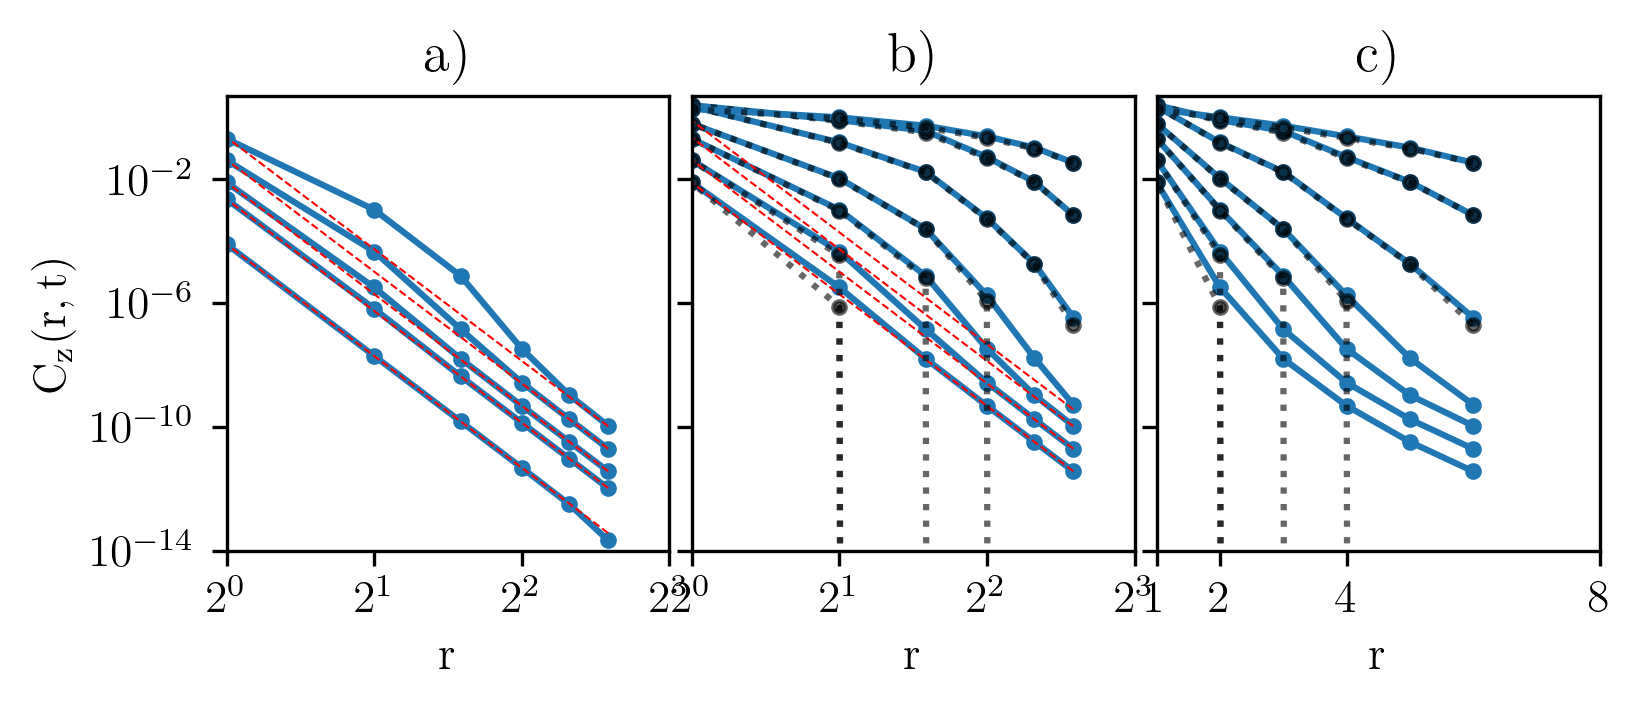

In [19]:
ts1 = [0.001,0.005,0.01,0.025,0.05]
Tis1 = []
for t in ts1:
    Tis1.append(np.argmin(np.abs(T-t)))

ts2 = [0.01,0.025,0.05,0.1,0.25,0.5,1]
Tis2 = []
for t in ts2:
    Tis2.append(np.argmin(np.abs(T-t)))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=set_size(subplots=(1,3)),dpi=300,sharey=True)
for ti in Tis1:
    ax1.plot(rvals[0:7],red[3][ti,:],label="t={:.2f}".format(T[ti]),color="C0",marker=".")
    ax1.plot(rvals[0:7],5*16/rvals[0:7]**12 * T[ti]**2,color="red",ls="dashed",lw=0.5)

ax1.set_xlabel("r")
ax1.set_xscale("log",base=2)
ax1.set_yscale("log")
ax1.set_ylabel(r"$\mathrm{C_z(r,t)}$")
ax1.set_ylim(1e-14,5)
ax1.set_xlim(1,N//2+0.5)
ax1.set_xticks([1,2,4,8])
ax1.set_title("a)")
#ax1.legend(loc="lower left")

ind = 0
for ti in Tis2:
    ax2.plot(rvals[0:7],red[3][ti,:],label="t={:.2f}".format(T[ti]),color="C0",marker=".")
    ax2.plot(rvals[0:7],red_nn[3][ti,:],ls="dotted",c="black",alpha=0.6,marker=".")
    if ind <= 3:
        ax2.plot(rvals[0:7],5*16/rvals[0:7]**12 * T[ti]**2,color="red",ls="dashed",lw=0.5)
        ind += 1

ax2.set_xlabel("r")
ax2.set_xscale("log",base=2)
ax2.set_yscale("log")
ax2.set_xlim(1,N//2+0.5)
ax2.set_xticks([1,2,4,8])
ax2.set_title("b)")



for ti in Tis2:
    ax3.plot(rvals[0:7],red[3][ti,:],label="t={:.2f}".format(T[ti]),color="C0",marker=".")
    ax3.plot(rvals[0:7],red_nn[3][ti,:],ls="dotted",c="black",alpha=0.6,marker=".")
    
ax3.set_xlabel("r")
ax3.set_yscale("log")
ax3.set_xlim(1,N//2+0.5)
ax3.set_xticks([1,2,4,8])
ax3.set_title("c)")


plt.subplots_adjust(wspace=0.05, hspace=0.05)
# plt.savefig(figurepath/"spat_zz.pdf",format="pdf",bbox_inches='tight',dpi=600)
# plt.show()

(2.0, 6.5)

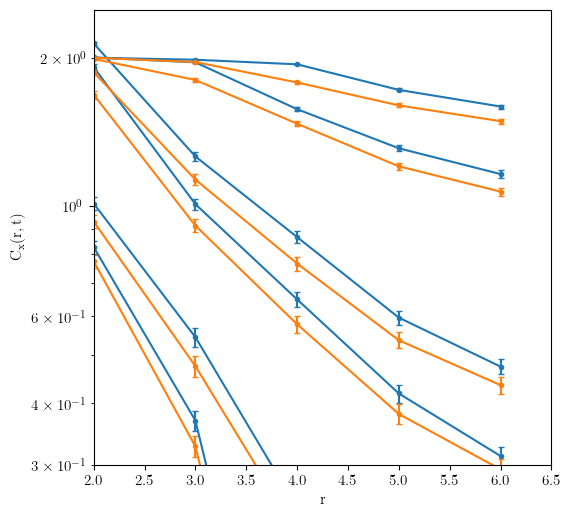

In [20]:
fig = plt.figure(figsize=set_size())
ax1 = fig.add_subplot(111)

ts1 = [0.5,1.0,5.0,10,100,500]
Tis1 = []
for t in ts1:
    Tis1.append(np.argmin(np.abs(T-t)))

for ti in Tis1:
    #ax1.plot(rvals[0:7],red[3][ti,:],label="t={:.2f}".format(T[ti]),color="C0",marker=".")
    #ax1.plot(rvals[0:7],red_nn[3][ti,:],label="t={:.2f}".format(T[ti]),color="C1",marker=".")
    ax1.errorbar(rvals[0:7],red[3][ti,:],yerr=red_sem[3][ti,:],label="t={:.2f}".format(T[ti]),color="C0",marker=".",capsize=2)
    ax1.errorbar(rvals[0:7],red_nn[3][ti,:],yerr=red_sem_nn[3][ti,:],label="t={:.2f}".format(T[ti]),color="C1",marker=".",capsize=2)
    #ax1.plot(rvals[0:7],5*16/rvals[0:7]**12 * T[ti]**2,color="red",ls="dashed",lw=0.5)
    #ax1.fill_between(rvals[0:7], red[3][ti,:]-red_sem[3][ti,:], red[3][ti,:]+red_sem[3][ti,:],fc="C0")
    #ax1.fill_between(rvals[0:7], red_nn[3][ti,:]-red_sem_nn[3][ti,:], red_nn[3][ti,:]+red_sem_nn[3][ti,:],fc="black")

ax1.set_xlabel("r")
#ax1.set_xscale("log",base=2)
ax1.set_yscale("log")
ax1.set_ylabel(r"$\mathrm{C_x(r,t)}$")
ax1.set_ylim(3e-1,2.5)
ax1.set_xlim(2,N//2+0.5)
#ax1.set_xticks([1,2,4,6])

(0.01, 3.5)

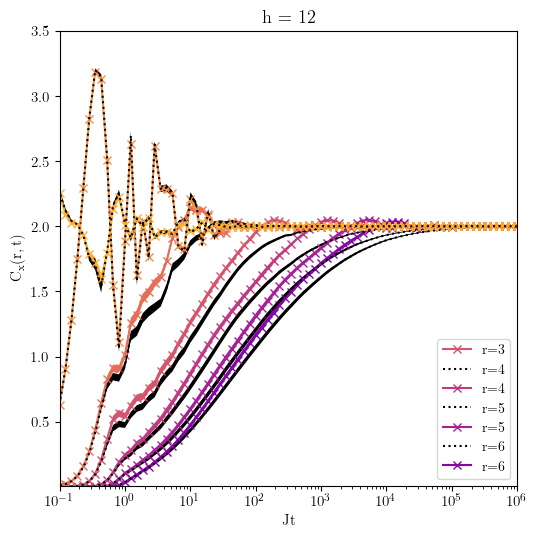

In [26]:
fig = plt.figure(figsize=set_size())
ax = fig.add_subplot(111)

NUM_COLORS = 19//2+2 #11
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
ax.set_xscale("log")
for j in range(0,N//2+1):
    ax.plot(T,red[3][:,j],label="r={}".format(rvals[j]),marker="x")
    ax.plot(T,red_nn[3][:,j],label="r={}".format(rvals[j]),ls="dotted",c="black")
    #ax.errorbar(T,red[3][:,j],yerr=red_sem[3][:,j],label="r={}".format(rvals[j]))
    ax.fill_between(T, red[3][:,j]-red_sem[3][:,j], red[3][:,j]+red_sem[3][:,j])
    ax.fill_between(T, red_nn[3][:,j]-red_sem_nn[3][:,j], red_nn[3][:,j]+red_sem_nn[3][:,j],fc="black")


handles, labels = ax.get_legend_handles_labels()
order = np.flip(np.arange(0,N//2+1,1))
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc="lower right")
ax.set_xlabel(r"Jt")
ax.set_ylabel(r"$\mathrm{C_x(r,t)}$")
ax.set_title("h = {}".format(hs[3]))
ax.set_xlim(1e-1,1e6)
ax.set_ylim(1e-2,3.5)
#ax.set_yscale("log")

In [34]:
T[55]

100.0

In [116]:
def model_exp(x,a,b):
    return a*np.exp(b*x)

def model_pl(x,a,b,c):
    return a*x**b+c

def model_str(x,a,b,c):
    return a*np.exp(b*np.power(x,c))

def model_ln(x,a,b,toff):
    return a*np.log(x-toff)+b

def model_ln_str(x,a,b,c,toff):
    return a*np.power(np.log(x-toff),b)+c

In [118]:
popt = []
perr = []
popt_ln = []
perr_ln = []
popt_pl = []
perr_pl = []
tfitmax = [55,55,55,55,55,55,55,55,55,55]
tfitmin = [42,42,42,42,42,42,42,42,42,42]
tmin = [1,1,1,1,1,1,1,1,1]
for j in range(0,7):
    poptj, pcovj = curve_fit(model,T[tfitmin[j]:tfitmax[j]],red_nn[3][tfitmin[j]:tfitmax[j],j])
    popt.append(poptj)
    perr.append(np.sqrt(np.diag(pcovj)))
    poptj, pcovj = curve_fit(model_ln,T[tfitmin[j]:tfitmax[j]],red_nn[3][tfitmin[j]:tfitmax[j],j])
    popt_ln.append(poptj)
    perr_ln.append(np.sqrt(np.diag(pcovj)))
    poptj, pcovj = curve_fit(model_pl,T[tfitmin[j]:tfitmax[j]],red[3][tfitmin[j]:tfitmax[j],j])
    popt_pl.append(poptj)
    perr_pl.append(np.sqrt(np.diag(pcovj)))

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [119]:
popt_pl

[array([ 6.59564429,  0.03979178, -6.75166505])]

/tmp/ipykernel_100743/2167013123.py:9: RuntimeWarning: invalid value encountered in log
  return a*np.log(x-toff)+b


(0.01, 3.5)

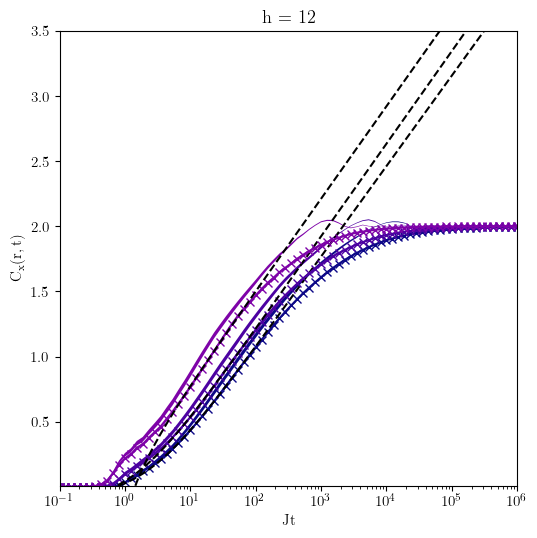

In [115]:
fig = plt.figure(figsize=set_size())
ax = fig.add_subplot(111)

NUM_COLORS = 13//2+2 #11
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
ax.set_xscale("log")
for j in range(0,3):#N//2+1):
    ax.plot(T,red_nn[3][:,j],label="r={}".format(rvals[j]),marker="x")
    #ax.plot(T,model(T,*popt[j]),c="black",ls="dashed")
    ax.plot(T,model_ln(T,*popt_ln[j]),c="black",ls="dashed")
    #ax.plot(T,model_ln_str(T,*popt_ln_str[j]),c="red",ls="dotted")
    #ax.plot(T,red_nn[3][:,j],label="r={}".format(rvals[j]),ls="dotted",c="black")
    #ax.errorbar(T,red[3][:,j],yerr=red_sem[3][:,j],label="r={}".format(rvals[j]))
    ax.fill_between(T, red[3][:,j]-red_sem[3][:,j], red[3][:,j]+red_sem[3][:,j])
    #ax.fill_between(T, red_nn[3][:,j]-red_sem_nn[3][:,j], red_nn[3][:,j]+red_sem_nn[3][:,j],fc="black")


handles, labels = ax.get_legend_handles_labels()
order = np.flip(np.arange(0,N//2+1,1))
#ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc="lower right")
ax.set_xlabel(r"Jt")
ax.set_ylabel(r"$\mathrm{C_x(r,t)}$")
ax.set_title("h = {}".format(hs[3]))
ax.set_xlim(1e-1,1e6)
ax.set_ylim(1e-2,3.5)
#ax.set_yscale("log")

In [111]:
popt_ln

[array([ 0.31224892, -0.27198349, -0.97746239]),
 array([ 0.31782236, -0.1447591 , -0.36289123]),
 array([0.28036692, 0.30316426, 2.29173027]),
 array([0.2722394 , 0.72558975, 2.75989772]),
 array([ -0.06449718,   2.26483325, -10.67391498]),
 array([0.00769363, 1.98412167, 6.57933218]),
 array([ 7.05954221e-04,  1.99736749e+00, -3.65248022e+00])]

In [31]:
popt = []
perr = []
tfitmax = [10,10,10,10,10,10,10,10,10,10]
tfitmin = [0,0,0,0,0,0,0,0,0,0]
tmin = [1,1,1,1,1,1,1,1,1]
for j in range(0,7):
    poptj, pcovj = curve_fit(model,T[tfitmin[j]:tfitmax[j]],red[3][tfitmin[j]:tfitmax[j],j])
    popt.append(poptj)
    perr.append(np.sqrt(np.diag(pcovj)))

In [32]:
popt

[array([4.90366492e-08, 2.05878079e+00]),
 array([3.38906246e-07, 2.00672627e+00]),
 array([4.87248551e-06, 2.00370879e+00]),
 array([1.71750393e-04, 2.02243369e+00]),
 array([0.09372226, 2.26384654]),
 array([79.11923515,  1.99814866]),
 array([891.54973367,   1.99285004])]

In [33]:
for j in range(0,7):
    print(popt[j][0]*(7-j)**12)

678.7303455712961
737.7251306825046
1189.5716580104713
2881.4934496965616
49807.85367183544
324072.38716931635
891.5497336701837
